In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import numpy as np
import pandas as pd

import random
from collections import deque
import matplotlib.pylab as plt

In [2]:
from environment import CryptoEnvironment, ETFEnvironment
from utils import *

# Deep RL Agent

In [116]:
class Agent:
    
    def __init__(
                     self, 
                     portfolio_size,
                     is_eval = False, 
                     allow_short = True,
                 ):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell
        
        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.75
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99 # if greater than 0.5 than it is exploiting
        
        self.model = self._model()

    def _model(self):
        
        inputs = Input(shape=self.input_shape)        
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])

        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
            
        weights /= saved_sum
        return weights, saved_min, saved_sum
    
    def act(self, state):
        
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  
              
            saved_min = None
            
            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size))           
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        def restore_Q_from_weights_and_stats(action):            
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) 
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values    

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
            
            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)            
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

# Training agent

In [117]:
N_ASSETS = 53 #15
agent = Agent(N_ASSETS)
env = ETFEnvironment()

In [118]:
window_size = 180
episode_count = 50
batch_size = 32
rebalance_period = 90

Episode 0/50 epsilon 1.0


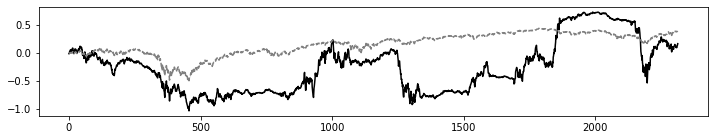

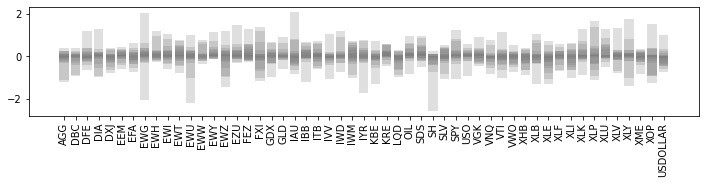

Episode 1/50 epsilon 1.0


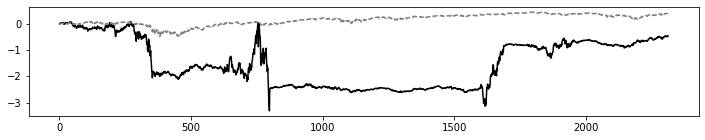

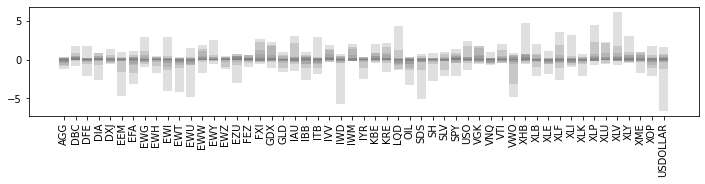

Episode 2/50 epsilon 0.99


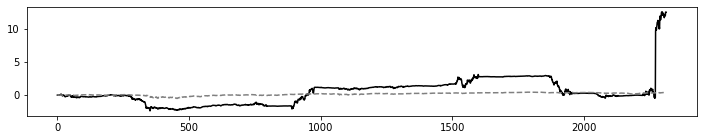

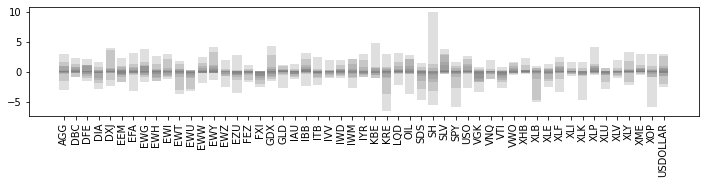

Episode 3/50 epsilon 0.9801


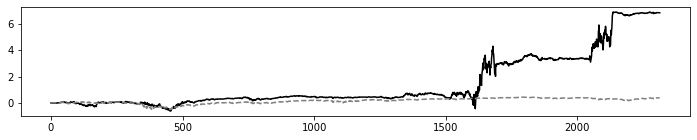

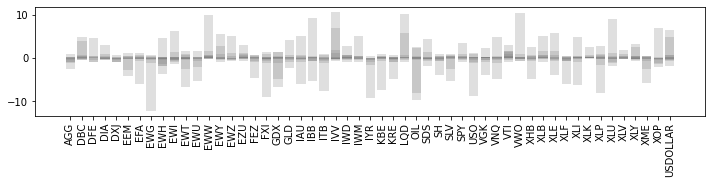

Episode 4/50 epsilon 0.9702989999999999


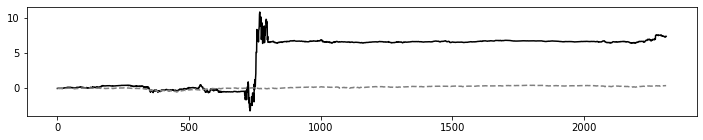

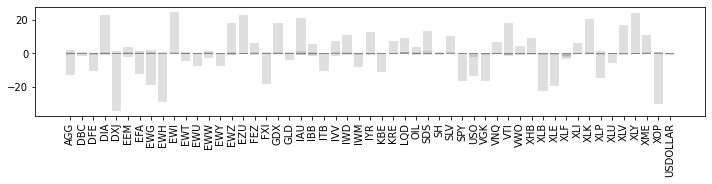

Episode 5/50 epsilon 0.96059601


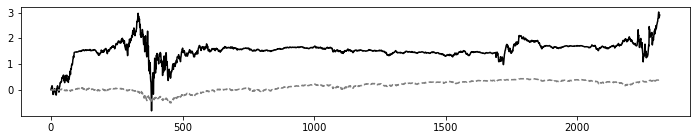

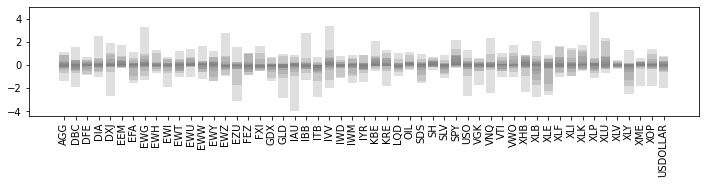

Episode 6/50 epsilon 0.96059601


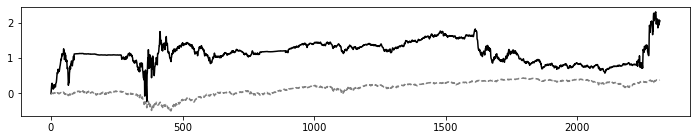

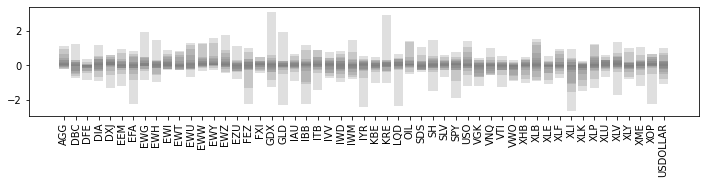

Episode 7/50 epsilon 0.9509900498999999


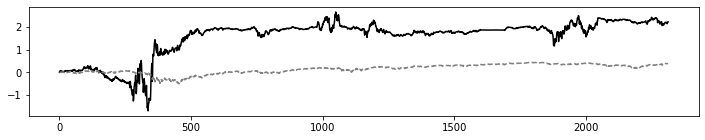

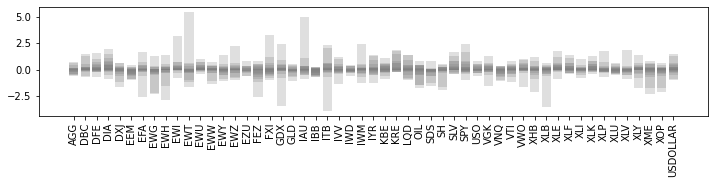

Episode 8/50 epsilon 0.9414801494009999


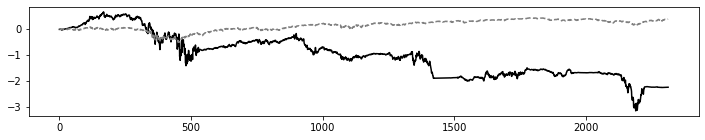

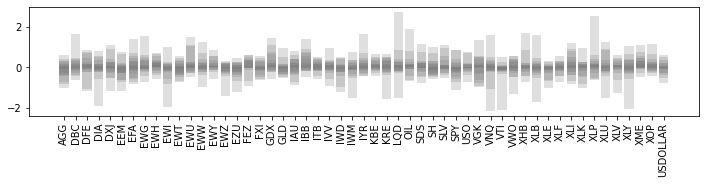

Episode 9/50 epsilon 0.9320653479069899


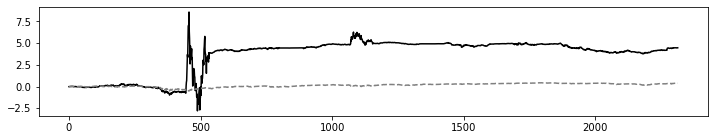

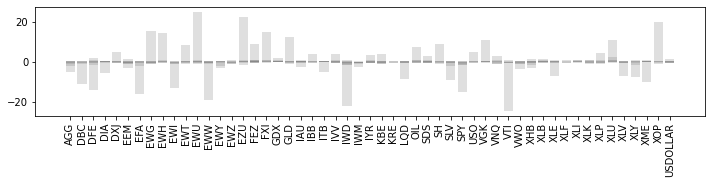

Episode 10/50 epsilon 0.92274469442792


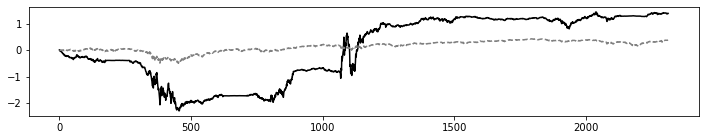

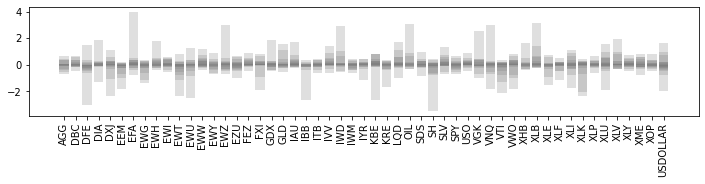

Episode 11/50 epsilon 0.92274469442792


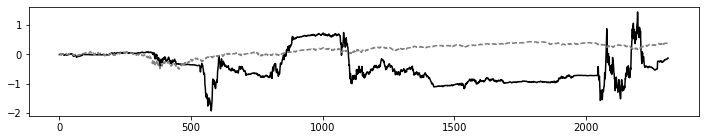

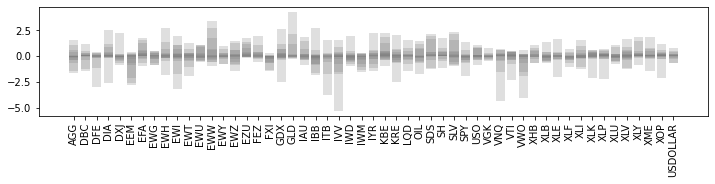

Episode 12/50 epsilon 0.9135172474836407


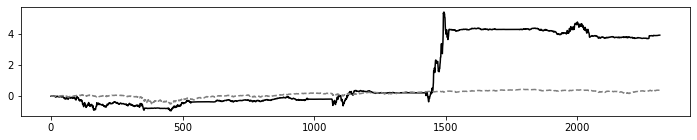

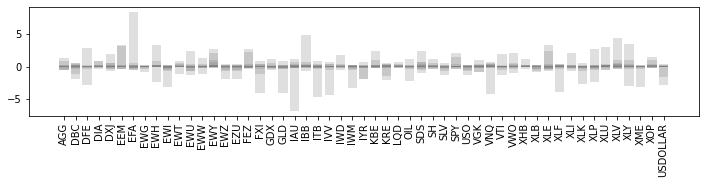

Episode 13/50 epsilon 0.9043820750088043


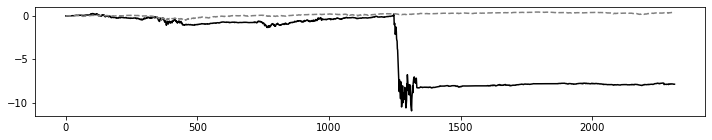

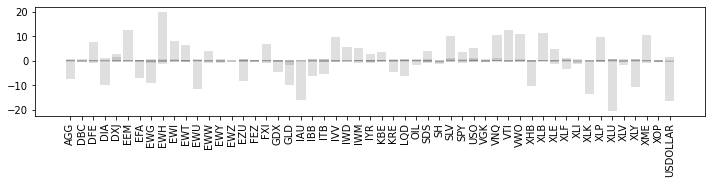

Episode 14/50 epsilon 0.8953382542587163


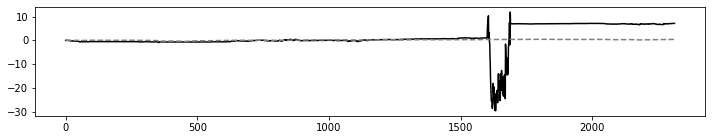

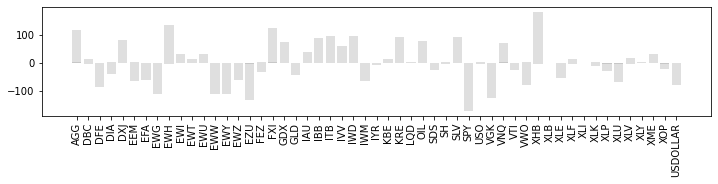

Episode 15/50 epsilon 0.8863848717161291


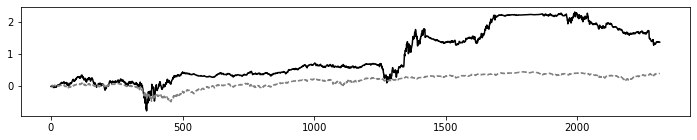

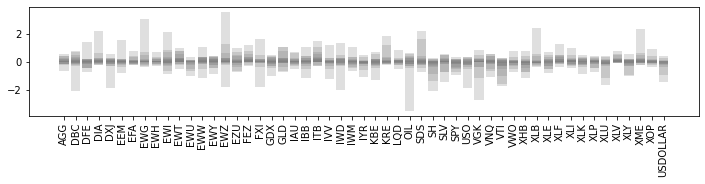

Episode 16/50 epsilon 0.8775210229989678


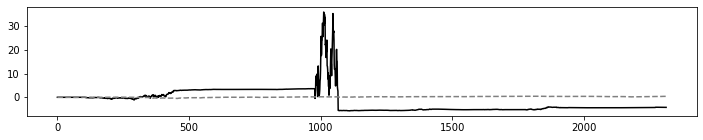

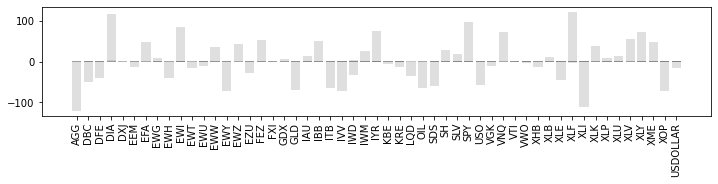

Episode 17/50 epsilon 0.8775210229989678


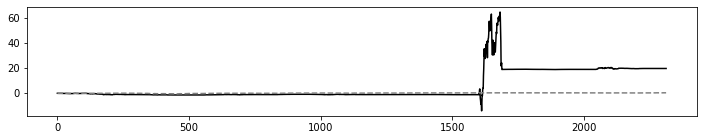

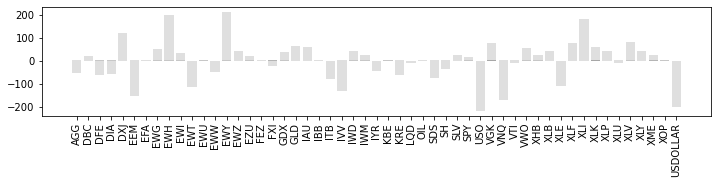

Episode 18/50 epsilon 0.8687458127689781


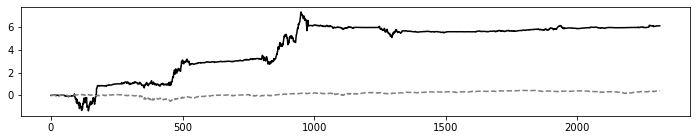

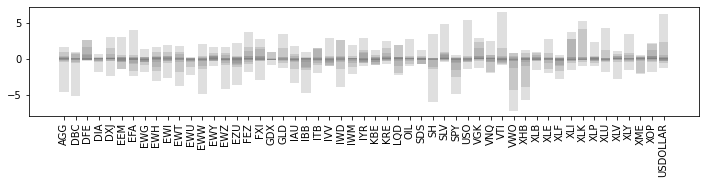

Episode 19/50 epsilon 0.8600583546412883


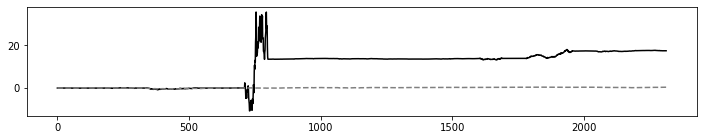

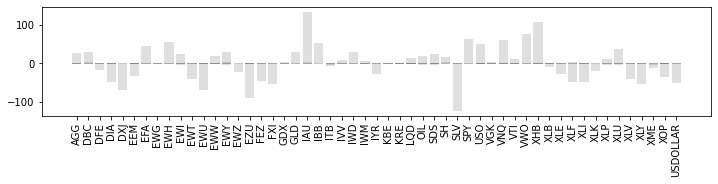

Episode 20/50 epsilon 0.8514577710948754


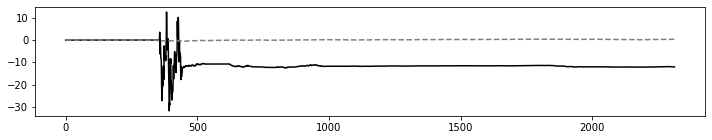

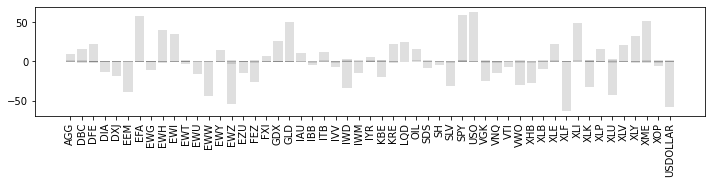

Episode 21/50 epsilon 0.8429431933839266


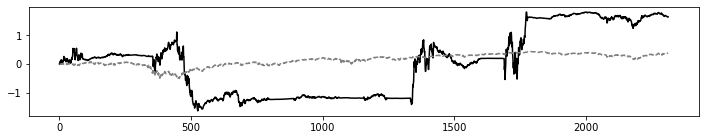

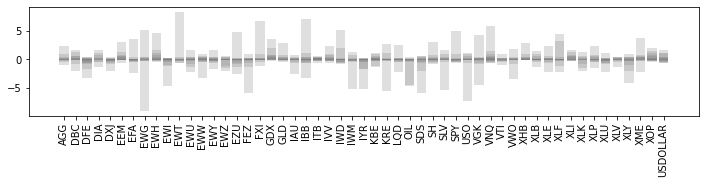

Episode 22/50 epsilon 0.8429431933839266


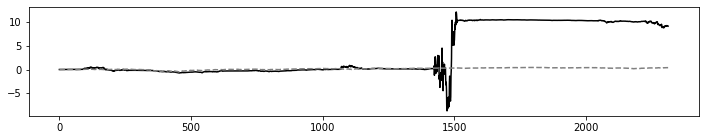

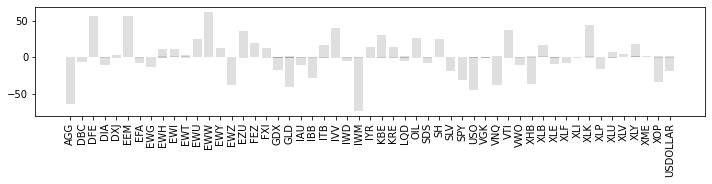

Episode 23/50 epsilon 0.8345137614500874


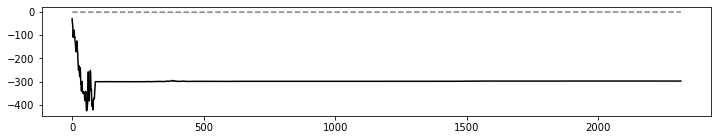

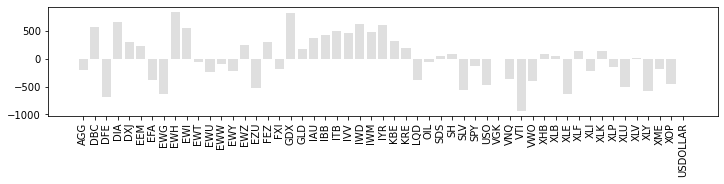

Episode 24/50 epsilon 0.8261686238355865


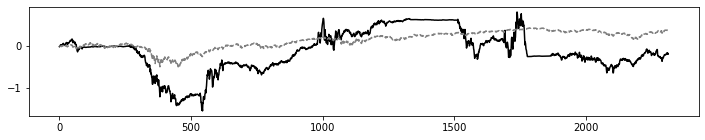

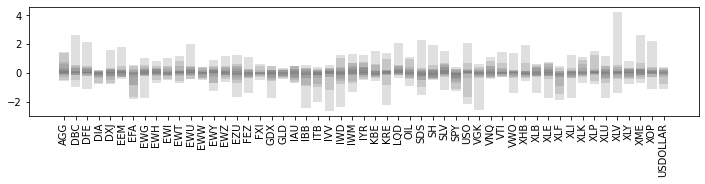

Episode 25/50 epsilon 0.8179069375972307


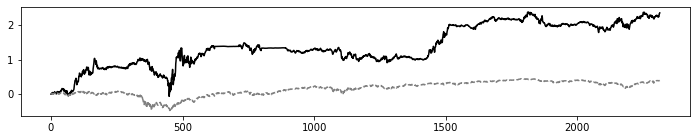

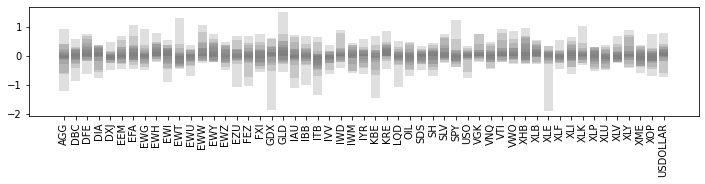

Episode 26/50 epsilon 0.8097278682212583


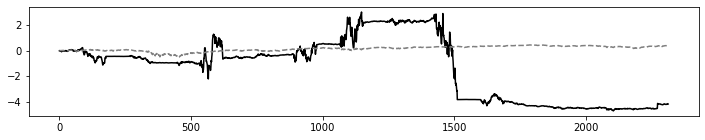

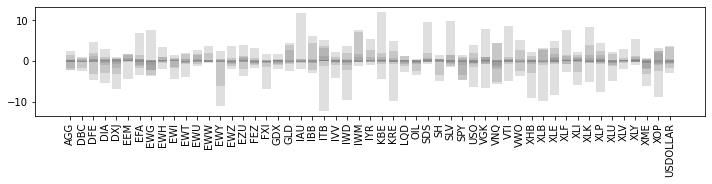

Episode 27/50 epsilon 0.8097278682212583


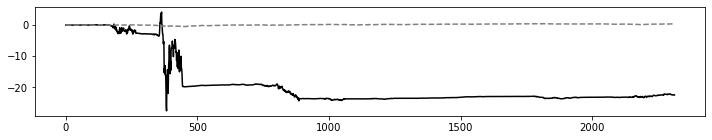

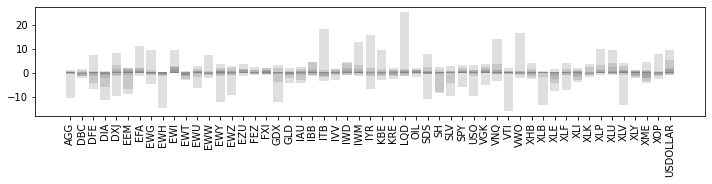

Episode 28/50 epsilon 0.8016305895390458


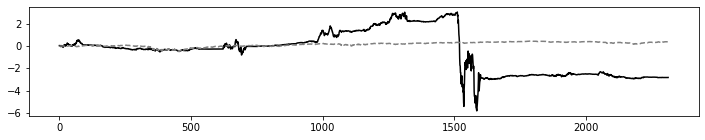

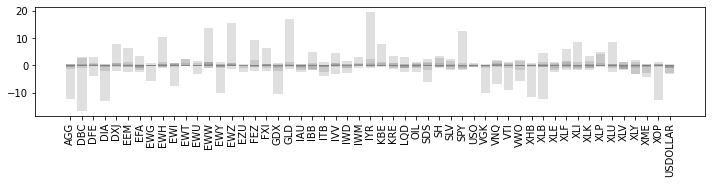

Episode 29/50 epsilon 0.7936142836436553


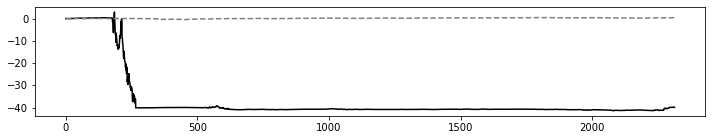

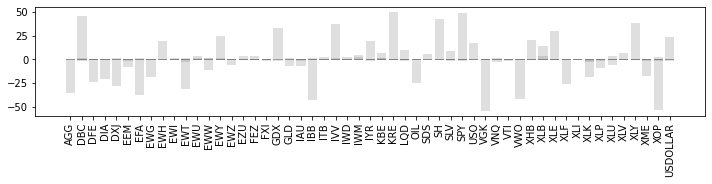

Episode 30/50 epsilon 0.7856781408072188


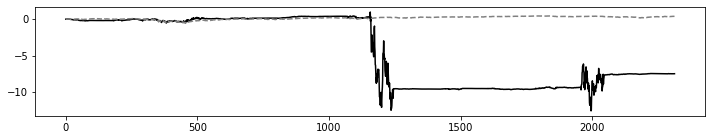

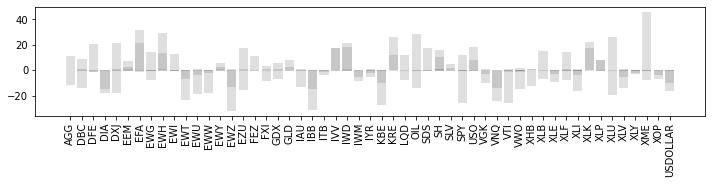

Episode 31/50 epsilon 0.7778213593991465


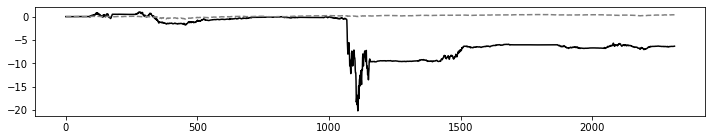

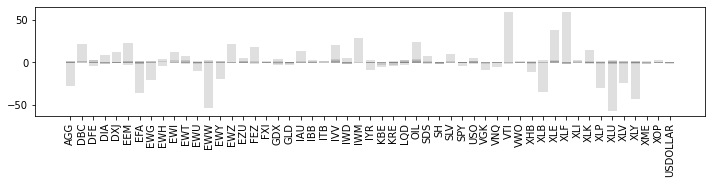

Episode 32/50 epsilon 0.7700431458051551


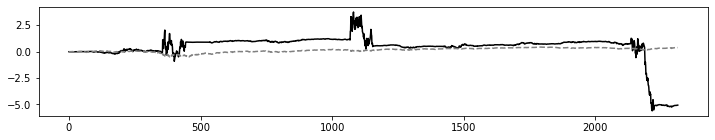

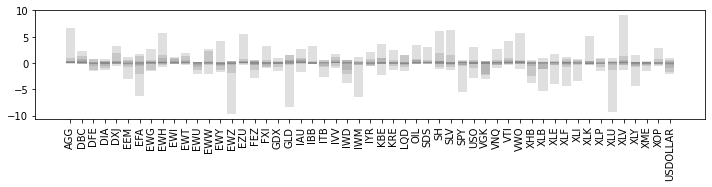

Episode 33/50 epsilon 0.7700431458051551


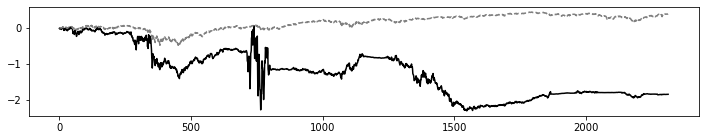

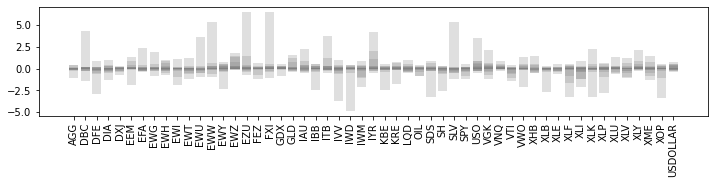

Episode 34/50 epsilon 0.7623427143471035


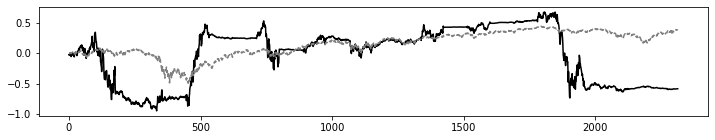

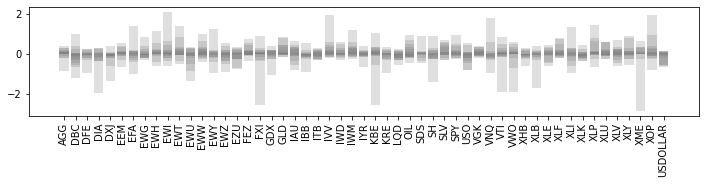

Episode 35/50 epsilon 0.7547192872036325


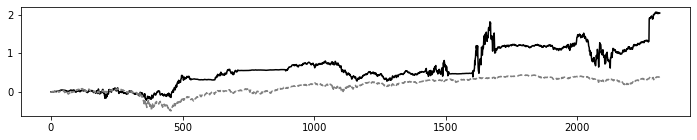

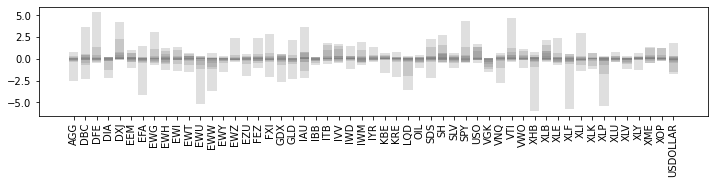

Episode 36/50 epsilon 0.7471720943315961


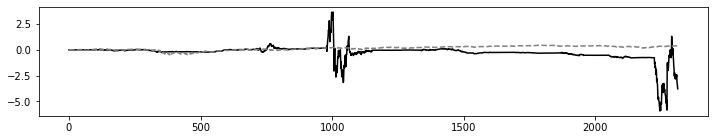

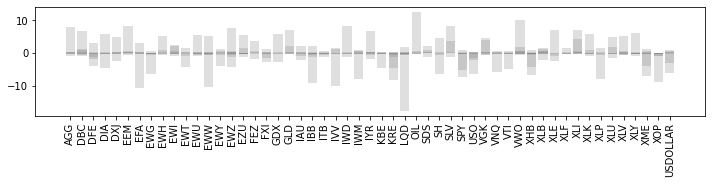

Episode 37/50 epsilon 0.7397003733882802


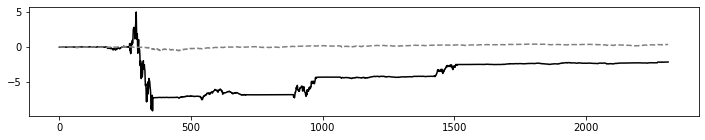

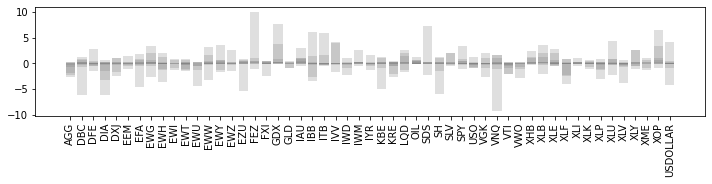

Episode 38/50 epsilon 0.7397003733882802


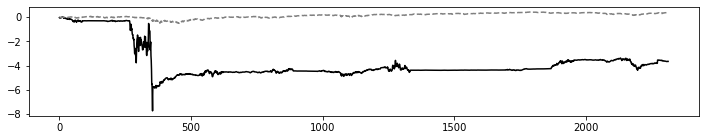

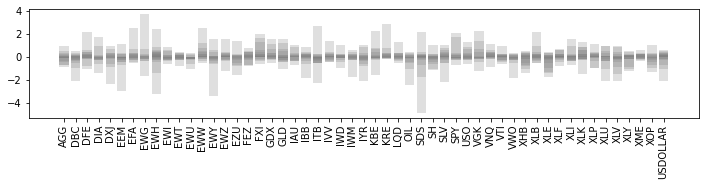

Episode 39/50 epsilon 0.7323033696543974


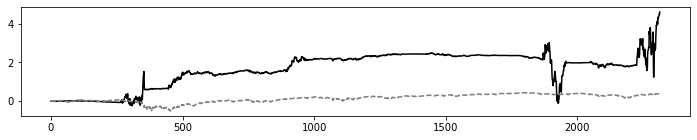

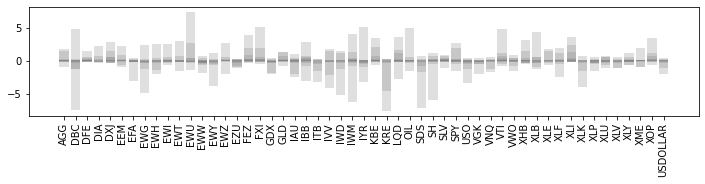

Episode 40/50 epsilon 0.7249803359578534


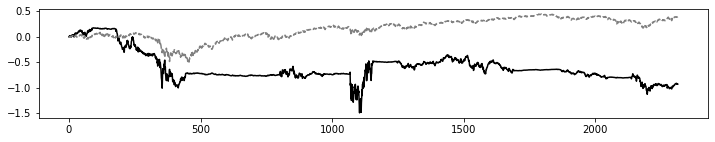

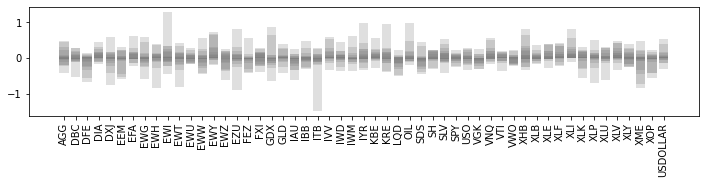

Episode 41/50 epsilon 0.7177305325982748


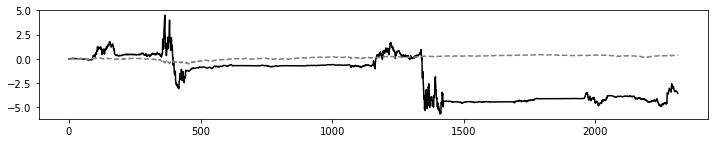

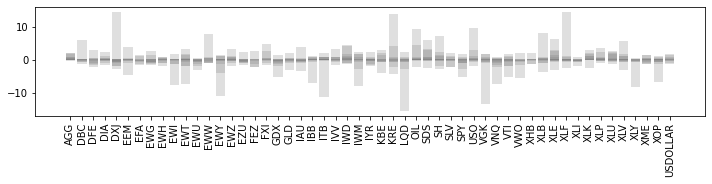

Episode 42/50 epsilon 0.7105532272722921


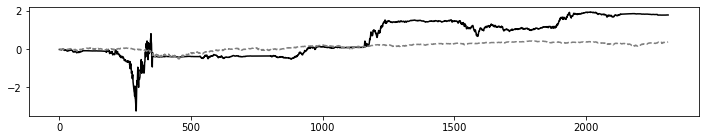

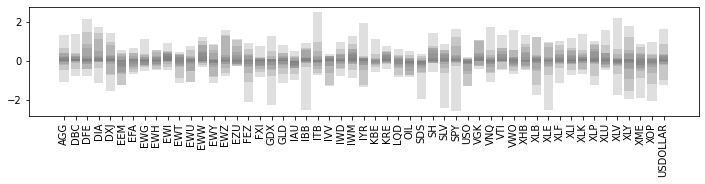

Episode 43/50 epsilon 0.7105532272722921


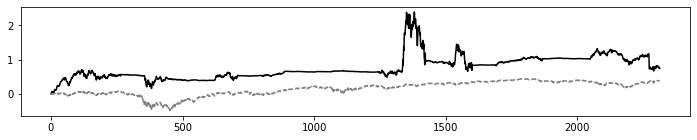

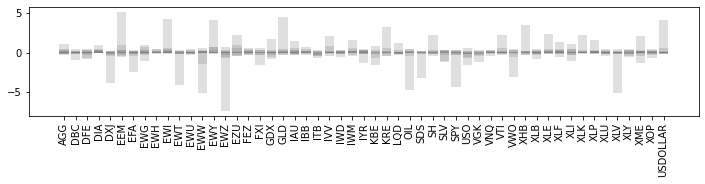

Episode 44/50 epsilon 0.7034476949995692


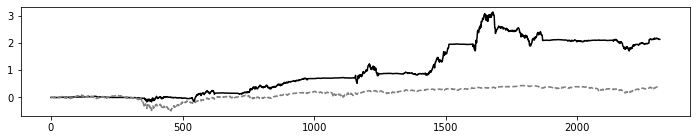

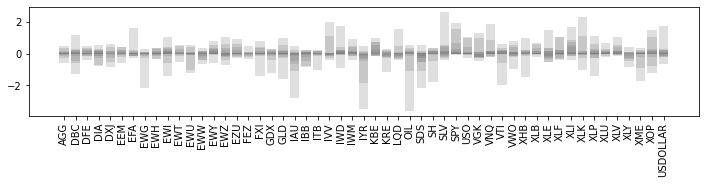

Episode 45/50 epsilon 0.6964132180495735


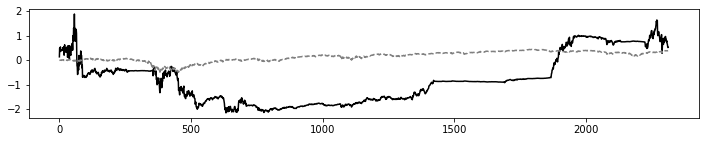

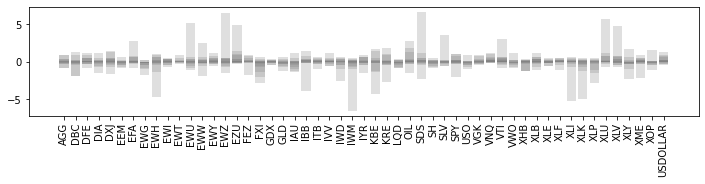

Episode 46/50 epsilon 0.6894490858690777


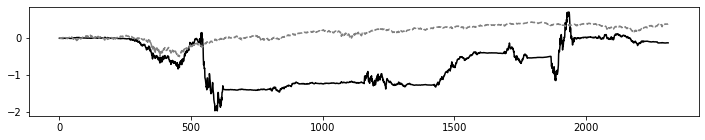

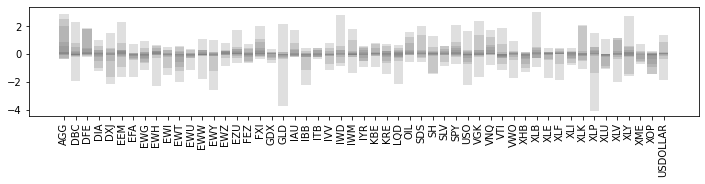

Episode 47/50 epsilon 0.682554595010387


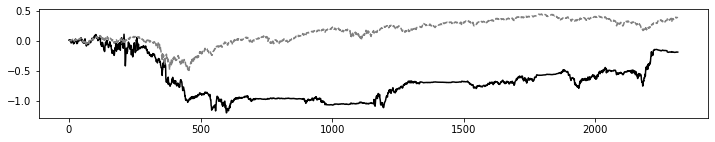

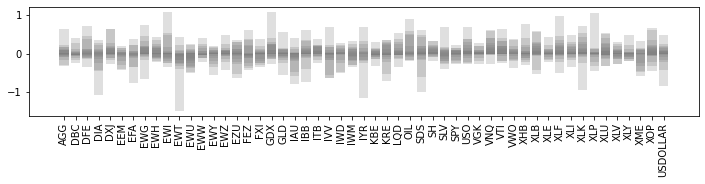

Episode 48/50 epsilon 0.6757290490602831


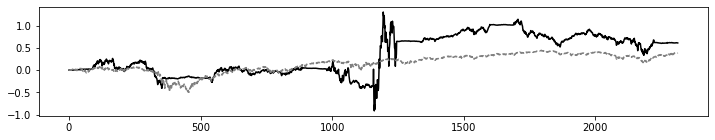

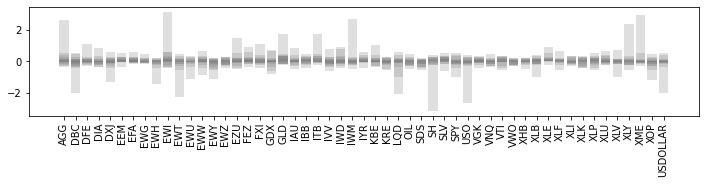

Episode 49/50 epsilon 0.6757290490602831


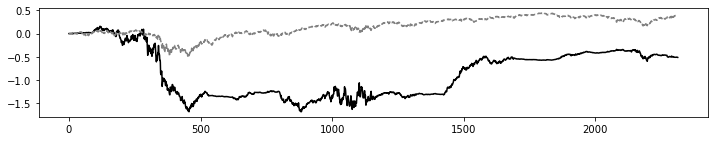

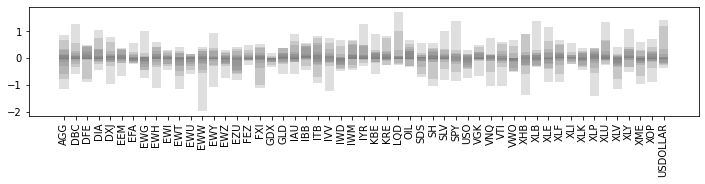

In [119]:
for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(env.data)
    
    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):

        date1 = t-rebalance_period
        
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0])

        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
            
        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()
    
    plt.figure(figsize = (12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    plt.show()
    

# Evaluating agent

In [120]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(env.data), rebalance_period):

    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
    
    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])

In [121]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]

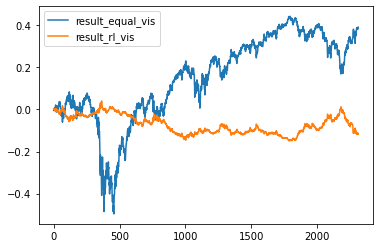

In [122]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'result_equal_vis')
plt.plot(np.array(result_rl_vis).cumsum(), label = 'result_rl_vis')
plt.legend()
plt.show()

In [123]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('RL AGENT', print_stats(result_rl_vis, result_equal_vis))

EQUAL [0.0002, 0.0125, 0.2181, 0.0, 1.0]
RL AGENT [-0.0001, 0.0033, -0.2473, -0.0, -0.1961]


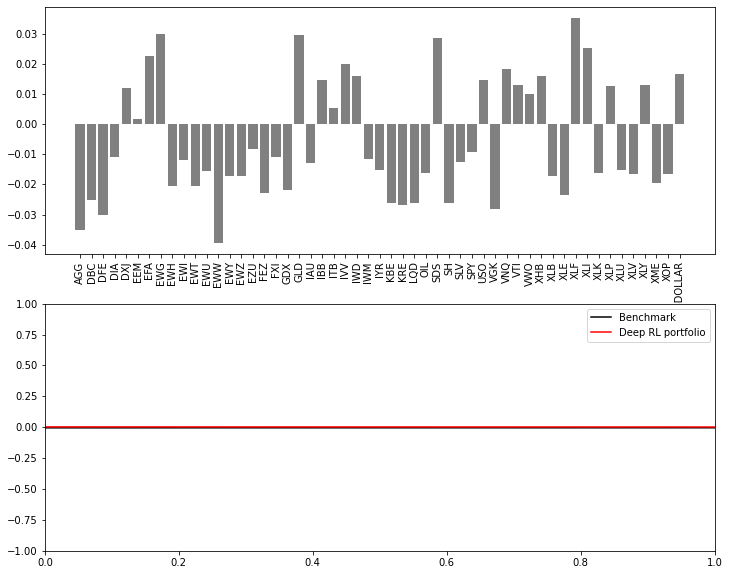

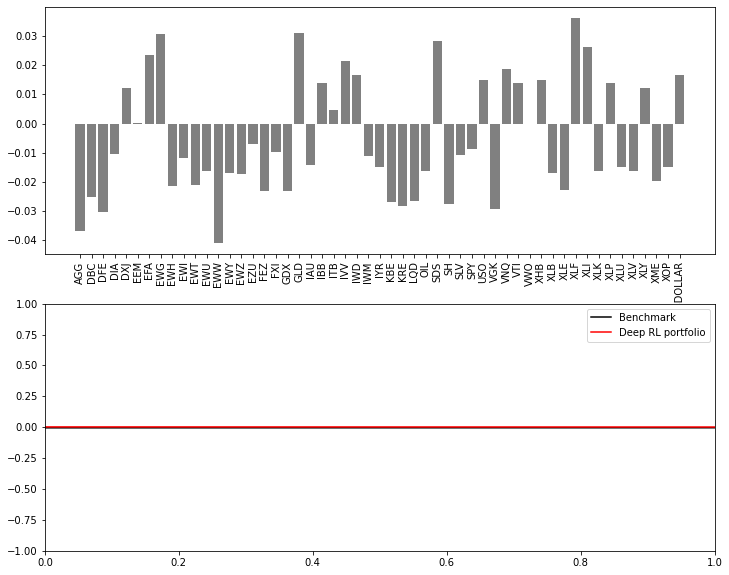

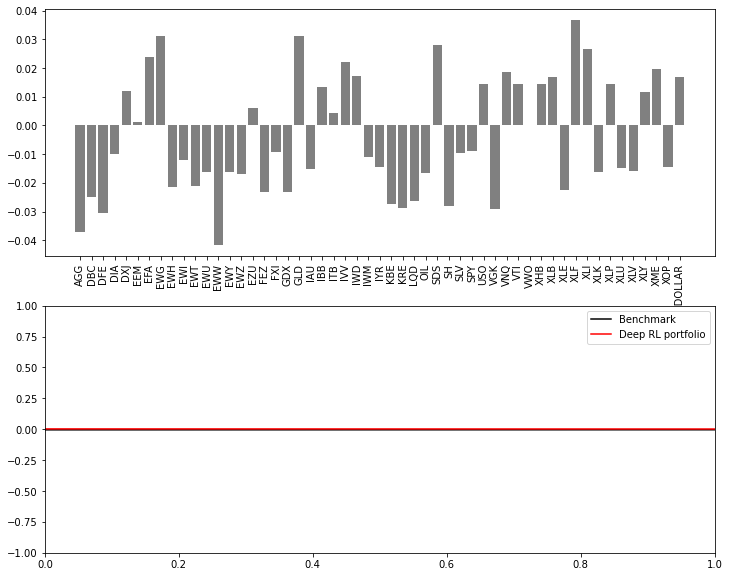

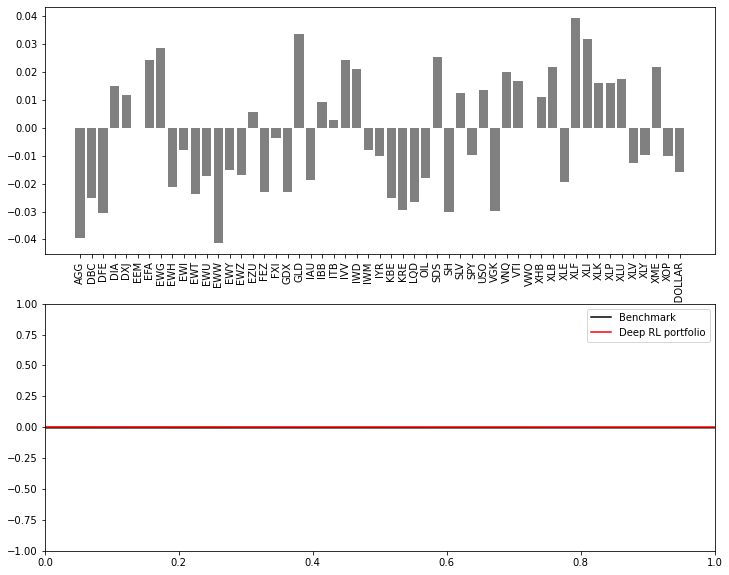

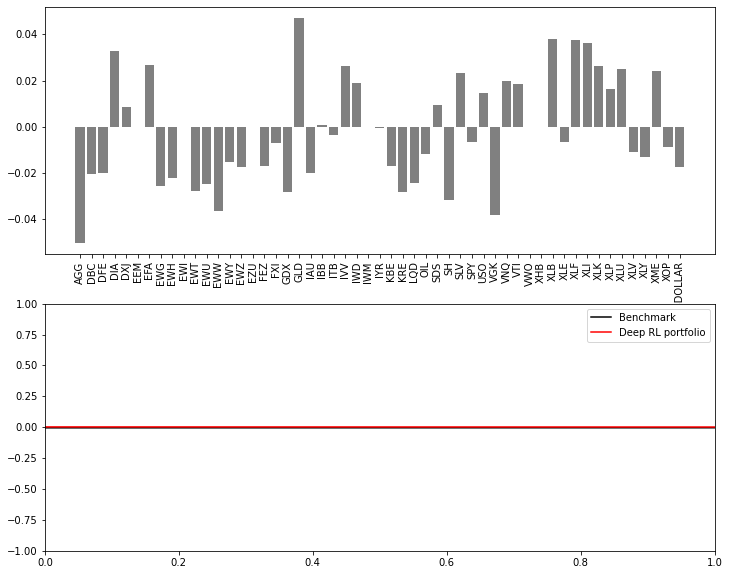

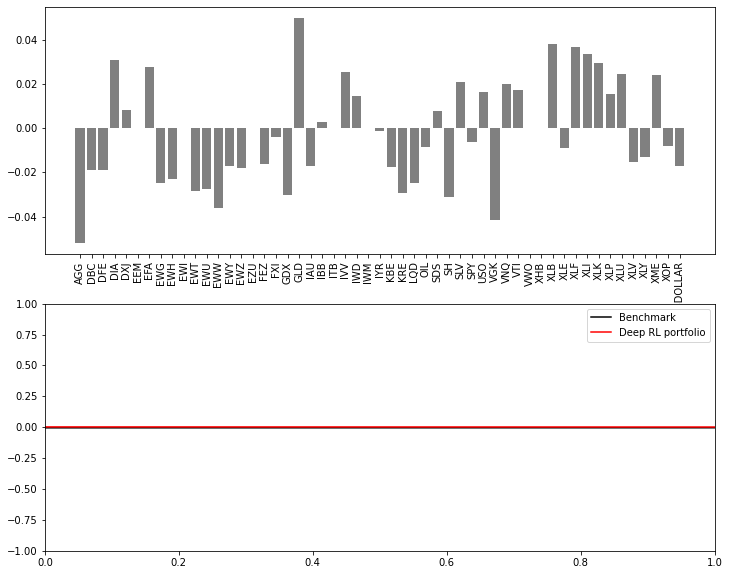

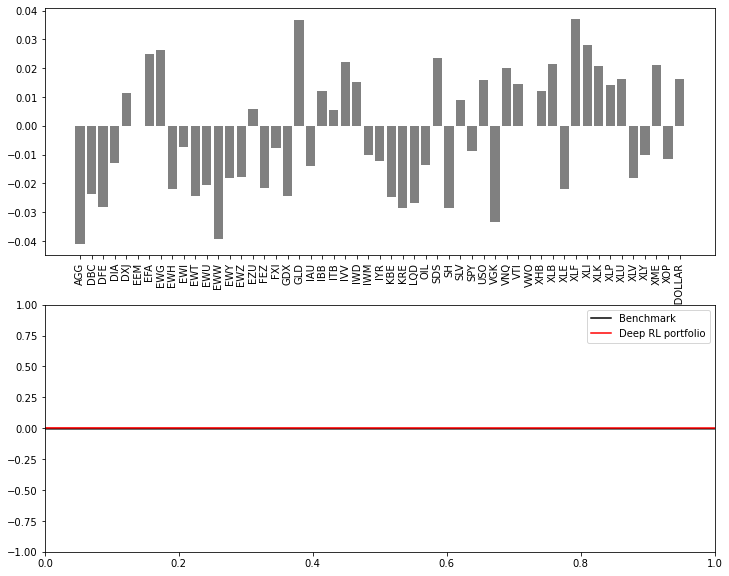

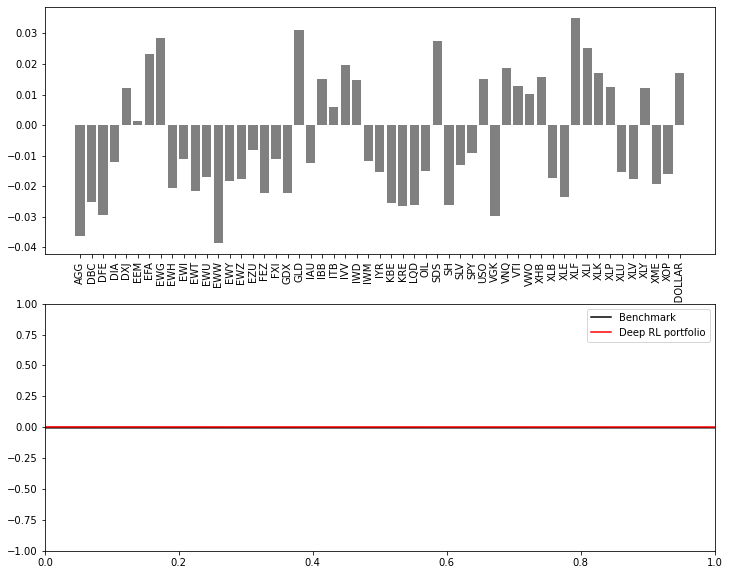

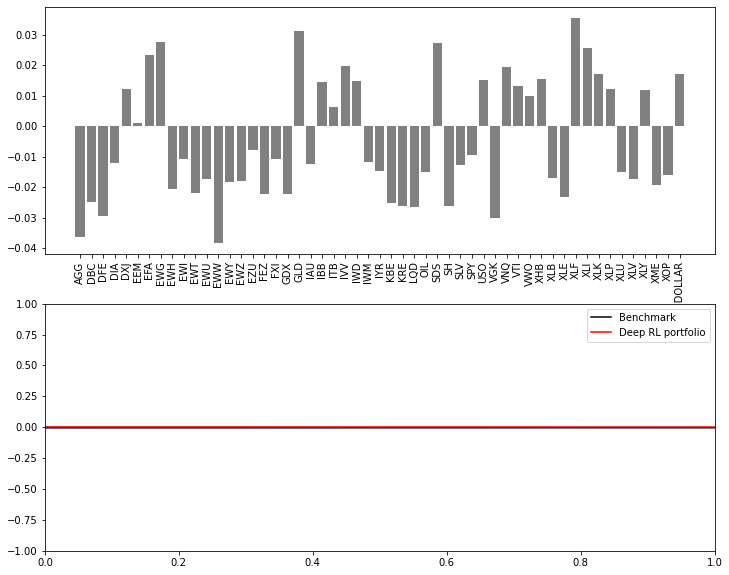

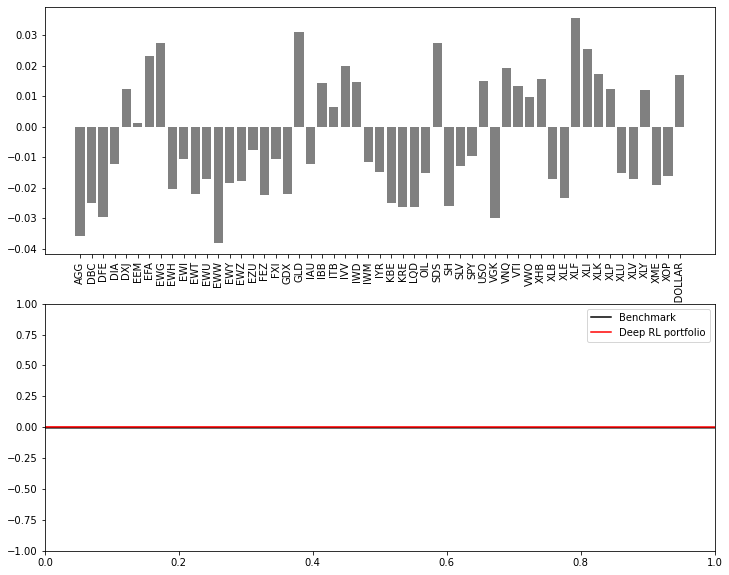

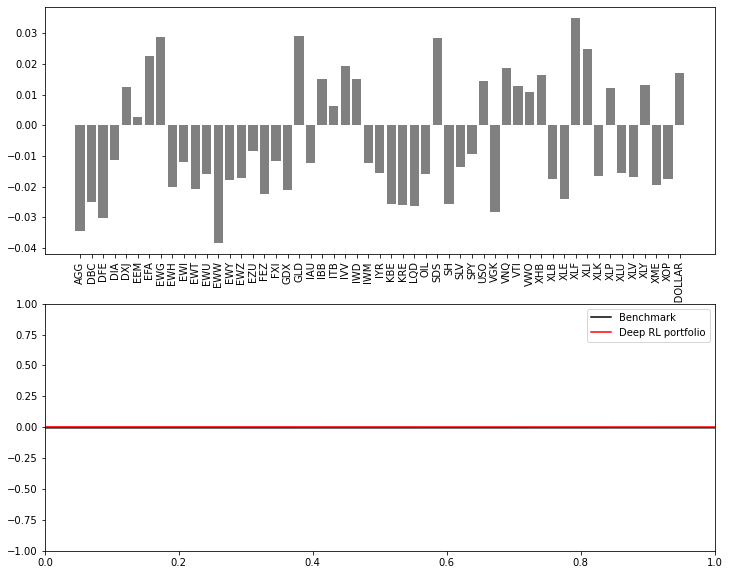

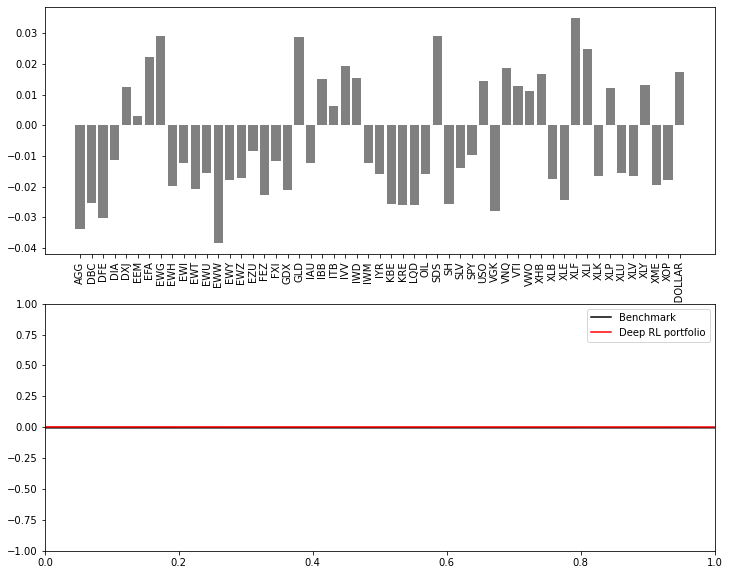

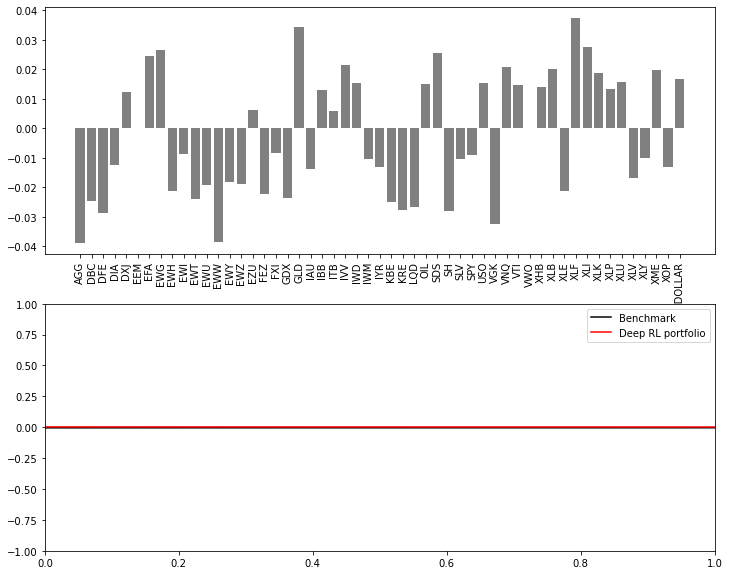

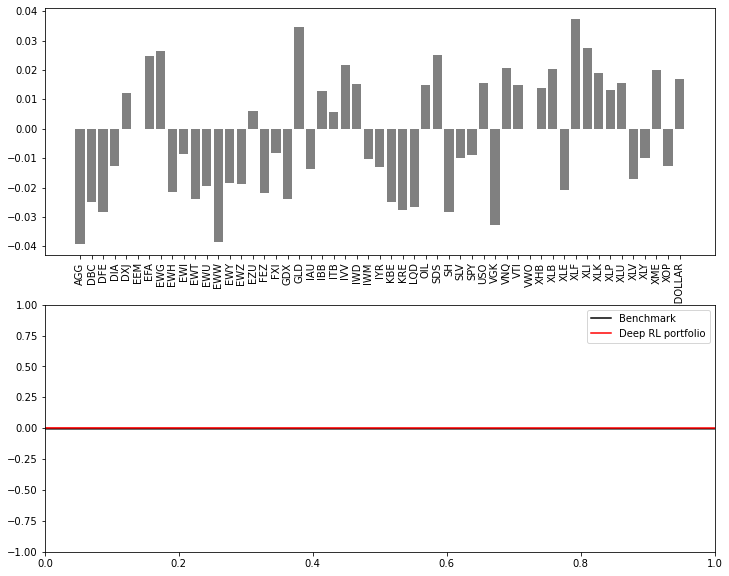

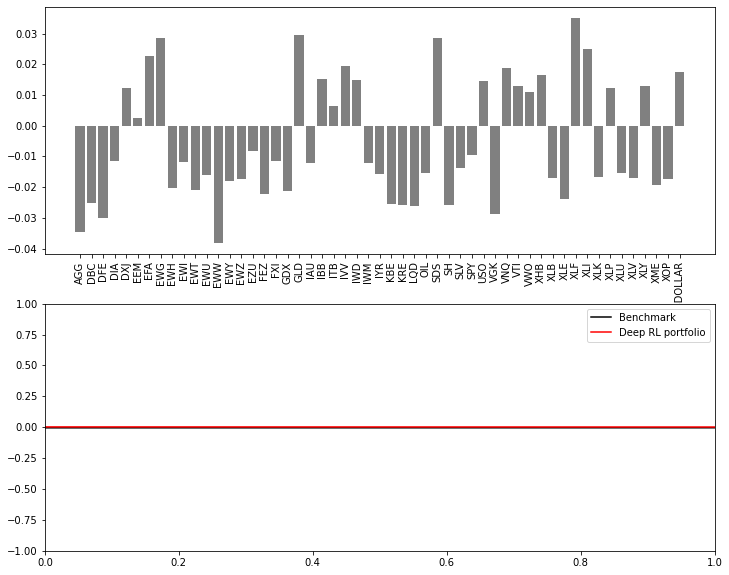

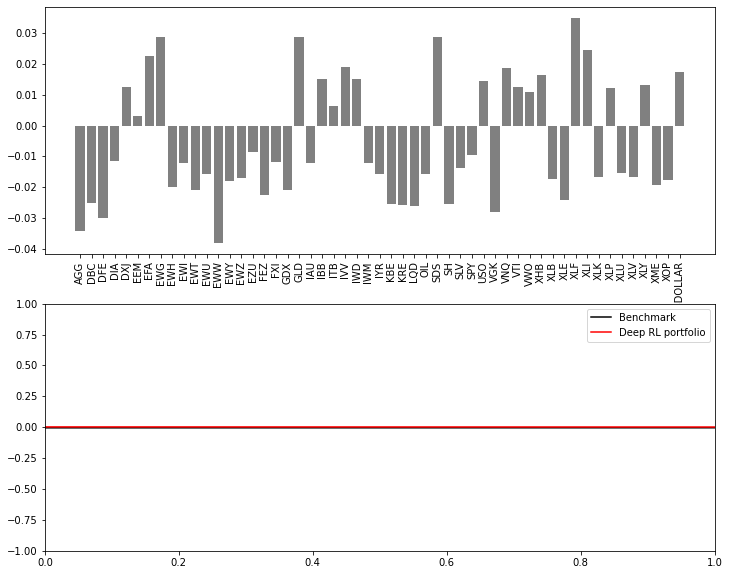

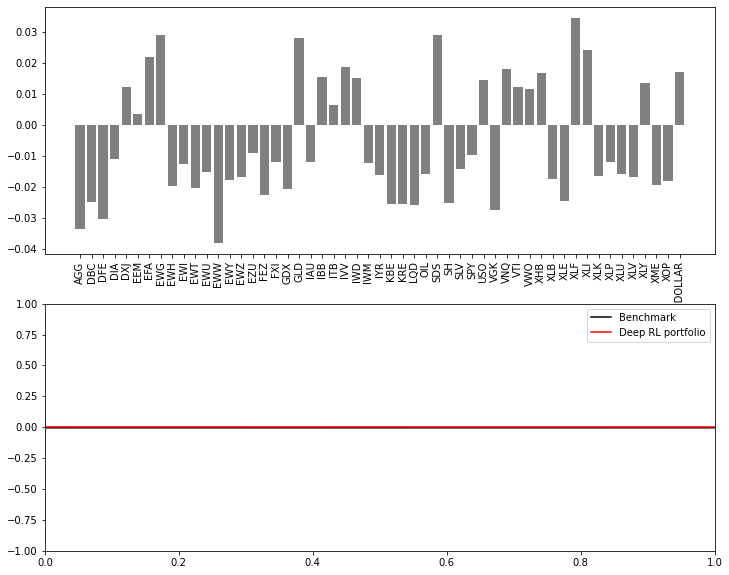

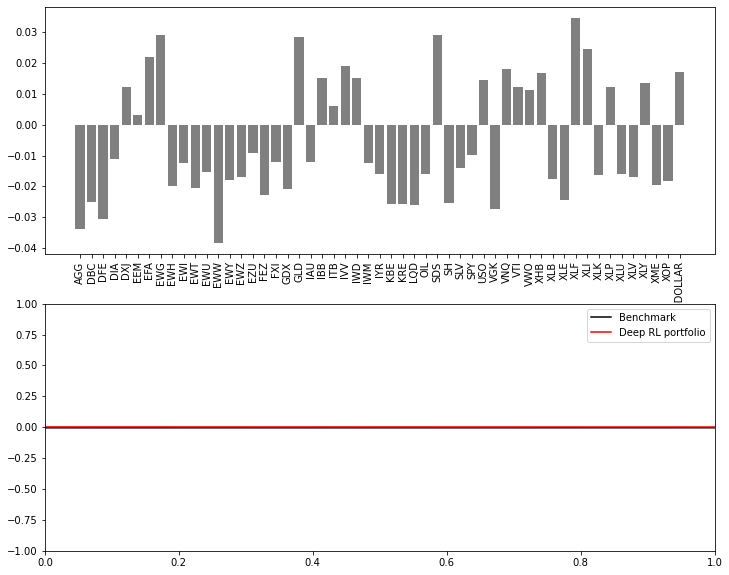

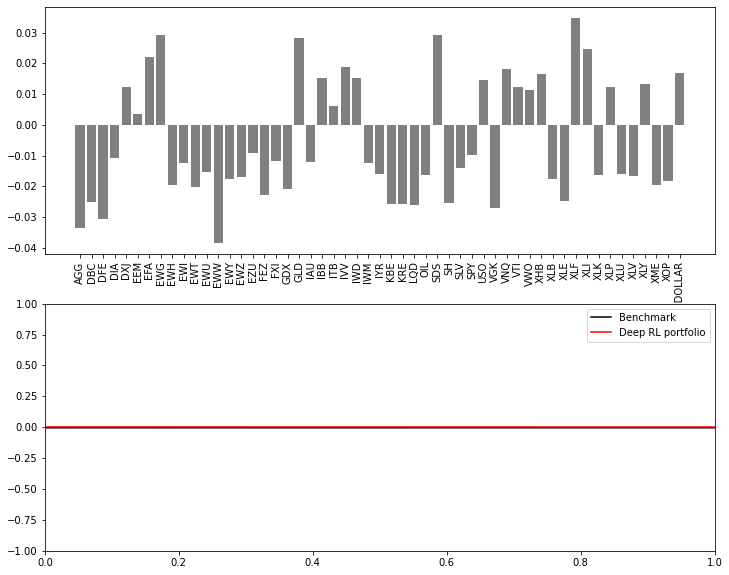

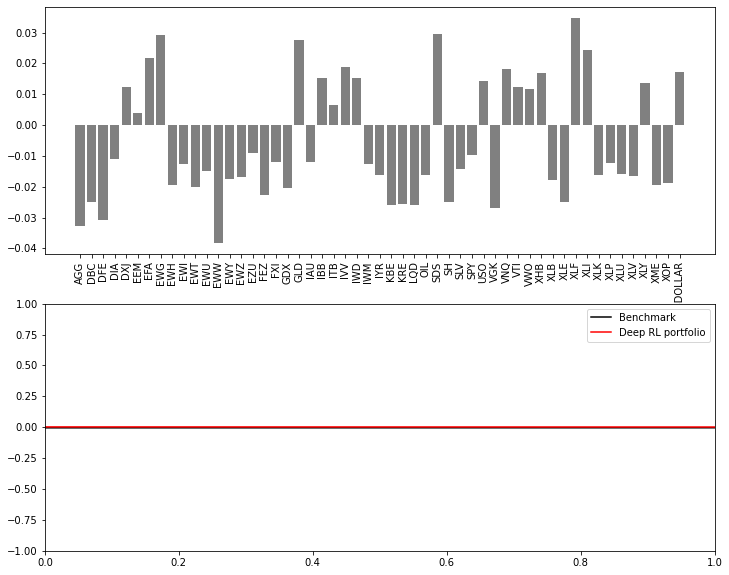

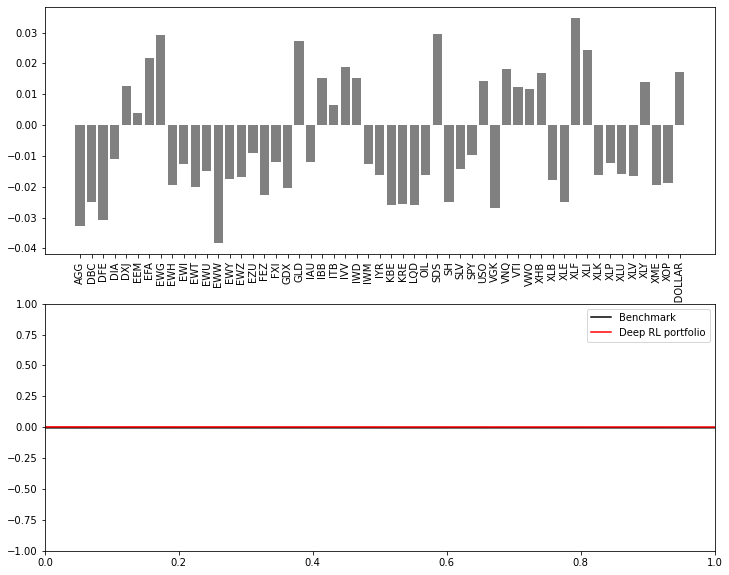

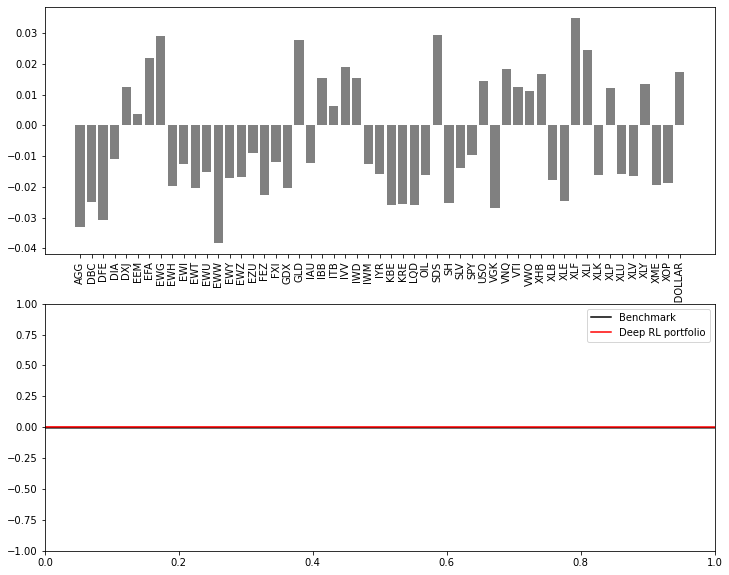

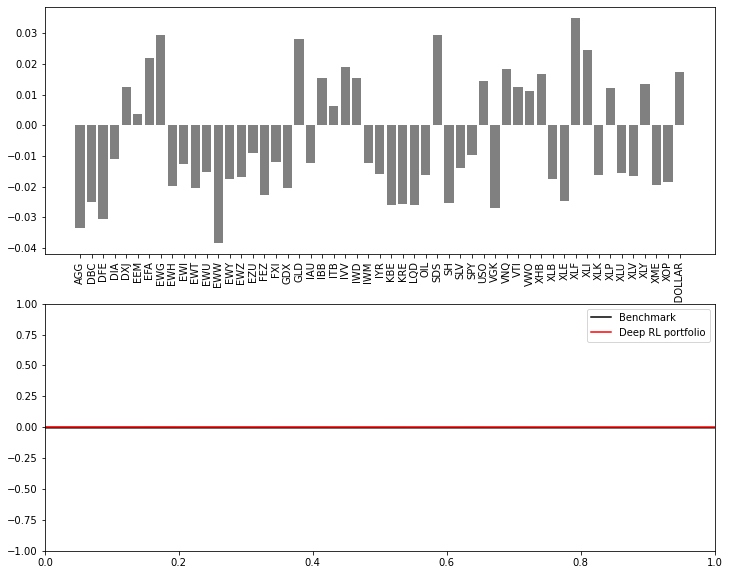

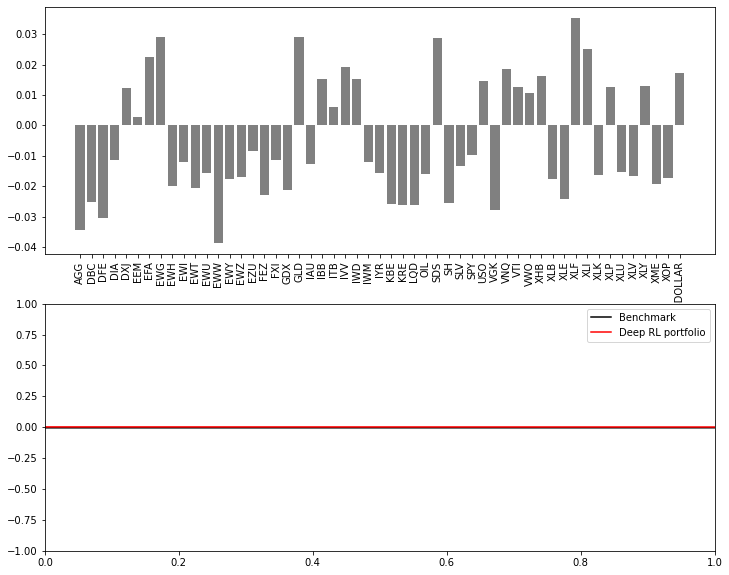

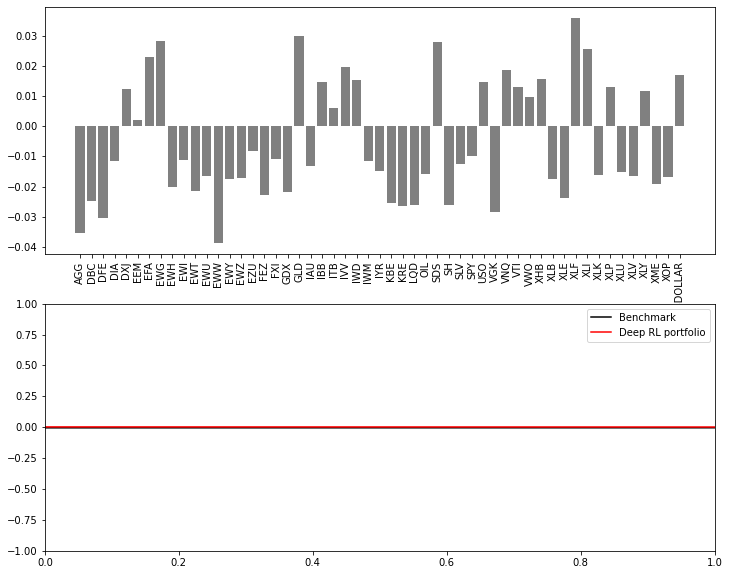

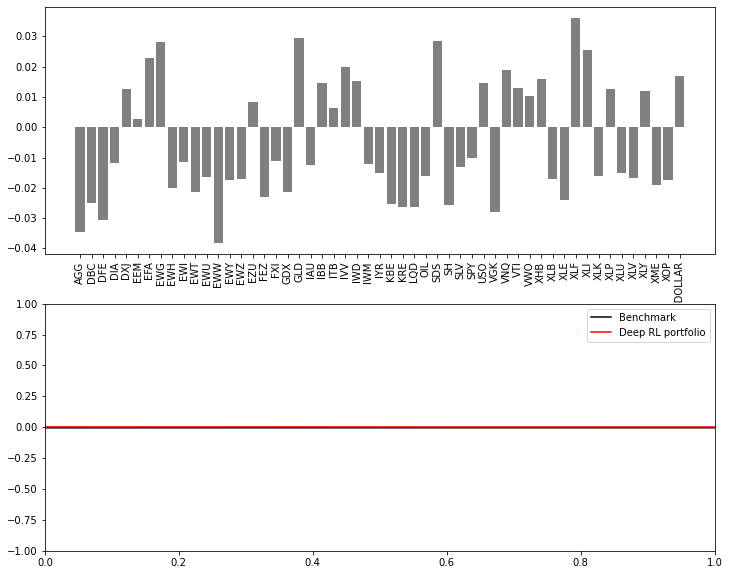

In [124]:
plot_results(result_equal, 
             result_rl, 
             actions_rl, 
             N_ASSETS,
             env.data.columns, 
             'Deep RL portfolio', './images_test1/rl/', 'series')

# Making GIFs

In [125]:
import imageio
import glob
import os

In [126]:
name = 'rl'
filenames = glob.glob('./images_test1/' + name + '/series*.jpg')
filenames.sort(key=lambda x: os.path.getmtime(x))
filenames

['./images_test1/rl/series0.jpg',
 './images_test1/rl/series1.jpg',
 './images_test1/rl/series2.jpg',
 './images_test1/rl/series3.jpg',
 './images_test1/rl/series4.jpg',
 './images_test1/rl/series5.jpg',
 './images_test1/rl/series6.jpg',
 './images_test1/rl/series7.jpg',
 './images_test1/rl/series8.jpg',
 './images_test1/rl/series9.jpg',
 './images_test1/rl/series10.jpg',
 './images_test1/rl/series11.jpg',
 './images_test1/rl/series12.jpg',
 './images_test1/rl/series13.jpg',
 './images_test1/rl/series14.jpg',
 './images_test1/rl/series15.jpg',
 './images_test1/rl/series16.jpg',
 './images_test1/rl/series17.jpg',
 './images_test1/rl/series18.jpg',
 './images_test1/rl/series19.jpg',
 './images_test1/rl/series20.jpg',
 './images_test1/rl/series21.jpg',
 './images_test1/rl/series22.jpg',
 './images_test1/rl/series23.jpg',
 './images_test1/rl/series24.jpg',
 './images_test1/rl/series25.jpg']

In [127]:
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./images_test1/' + name + '_gif.gif', images, duration=0.5)